In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from sklearn.cluster import MeanShift
from skimage.color import label2rgb

from PIL import Image

In [7]:
IMAGE_FOLDER = "../Sequences/01/"
n_images = len(os.listdir(IMAGE_FOLDER))
# images are 1100 x 700

../Sequences/01/t013.tif


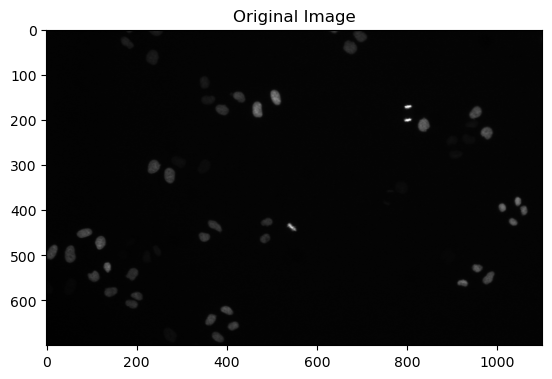

In [65]:
# Task 1-1: Segment all cells
# i = 1
# for image_file in os.listdir(IMAGE_FOLDER):
#     image_path = os.path.join(IMAGE_FOLDER, image_file)
    
#     img = cv2.imread(image_path)
    
#     plt.imshow(img)
#     i += 1
image_path = os.path.join(IMAGE_FOLDER, os.listdir(IMAGE_FOLDER)[13])
print(image_path)
img = cv2.imread(image_path, -1)
plt.imshow(img, 'gray')
plt.title('Original Image')
plt.show()

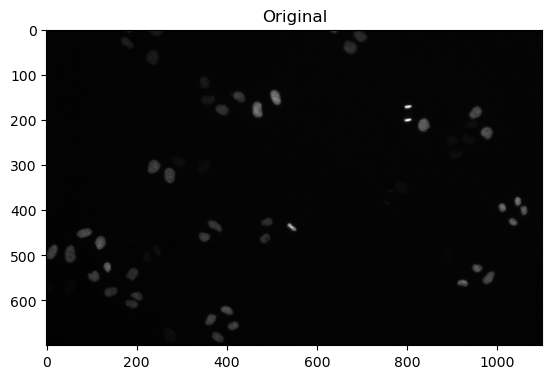

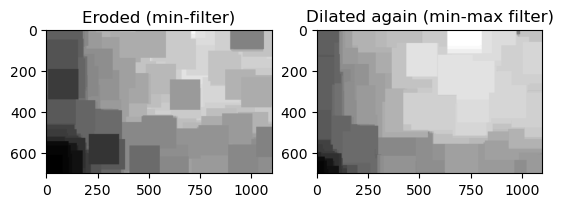

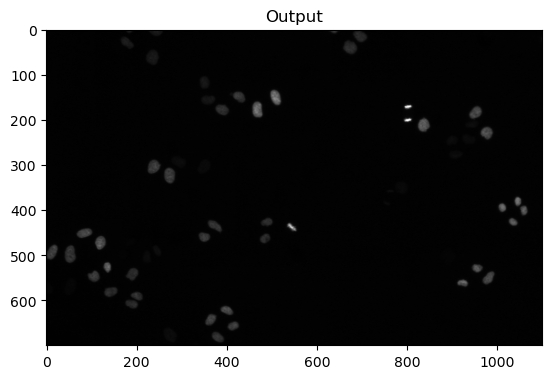

[[30 31 33 ... 43 44 35]
 [30 27 38 ... 38 34 36]
 [35 36 42 ... 44 37 36]
 ...
 [15 24 27 ... 32 31 28]
 [22 21 22 ... 32 24 33]
 [21 19 24 ... 30 37 28]]


In [66]:
# Testing min-max filter to remove background
img_test = img.copy()
plt.imshow(img, 'gray'), plt.title('Original')
plt.show()

kernel = np.ones((50,50),np.uint16)
img_erosion = cv2.erode(img_test, kernel, iterations=3)
img_dilated = cv2.dilate(img_erosion, kernel, iterations=3)

plt.subplot(1,2,1),plt.imshow(img_erosion, 'gray'), plt.title('Eroded (min-filter)')
plt.subplot(1,2,2),plt.imshow(img_dilated, 'gray'), plt.title('Dilated again (min-max filter)')
plt.show()

img_output = img_test.copy()

for i in range(len(img_test)):
    for j in range(len(img_test[0])):
        i_pixel = int(img_test[i][j])
        b_pixel = int(img_dilated[i][j])
        if b_pixel >= i_pixel:
            img_output[i][j] = 0
        else:
            img_output[i][j] = i_pixel - b_pixel

plt.imshow(img_output, 'gray'), plt.title('Output')
plt.show()
print(img_output)

min: 0, max: 3818


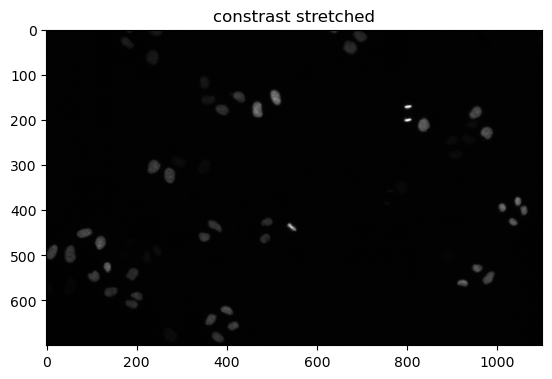

min: 0, max: 65535


In [40]:
# Contrast stretching
img_test = img_output.copy()

min_pixel = np.min(img_test)
max_pixel = np.max(img_test)
print(f'min: {min_pixel}, max: {max_pixel}')

for i in range(len(img_test)):
    for j in range(len(img_test[0])):
        img_test[i][j] = (img_test[i][j] - min_pixel)/(max_pixel-min_pixel)*65535

plt.imshow(img_test, 'gray'), plt.title('constrast stretched')
plt.show()
min_pixel = np.min(img_test)
max_pixel = np.max(img_test)
print(f'min: {min_pixel}, max: {max_pixel}')
img_output = img_test.copy()

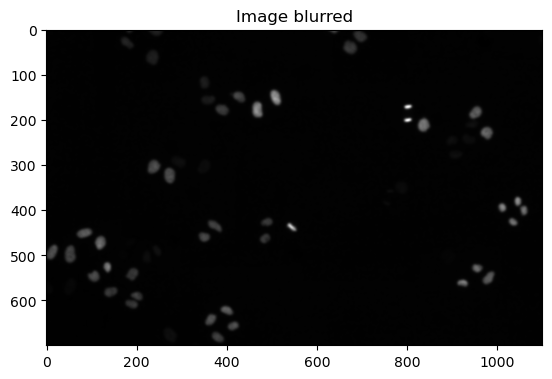

[[35 35 35 ... 41 41 41]
 [35 35 35 ... 42 42 42]
 [34 34 35 ... 44 44 44]
 ...
 [23 23 23 ... 30 30 30]
 [23 23 23 ... 31 30 30]
 [23 23 23 ... 31 31 30]]


In [53]:
img_blur = cv2.GaussianBlur(img_output, (5,5), cv2.BORDER_DEFAULT)
img_blur = cv2.GaussianBlur(img_blur, (5,5), cv2.BORDER_DEFAULT)
# img_blur = cv2.medianBlur(img_output, 7)
# img_blur = cv2.medianBlur(img_blur, 7)
plt.imshow(img_blur, 'gray'), plt.title('Image blurred')
plt.show()
img_output = img_blur.copy()
print(img_output)

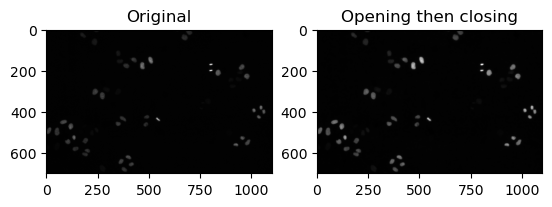

In [50]:
# Open then close operation
img_test = img_output.copy()

kernel = np.ones((5,5),np.uint16)
img1 = cv2.erode(img_test, kernel, iterations=1)
img2 = cv2.dilate(img1, kernel, iterations=1)
img3 = cv2.dilate(img2, kernel, iterations=1)
img4 = cv2.erode(img3, kernel, iterations=1)
plt.subplot(1,2,1),plt.imshow(img_test, 'gray'), plt.title('Original')
plt.subplot(1,2,2),plt.imshow(img4, 'gray'), plt.title('Opening then closing')
plt.show()

img_output = img4.copy()

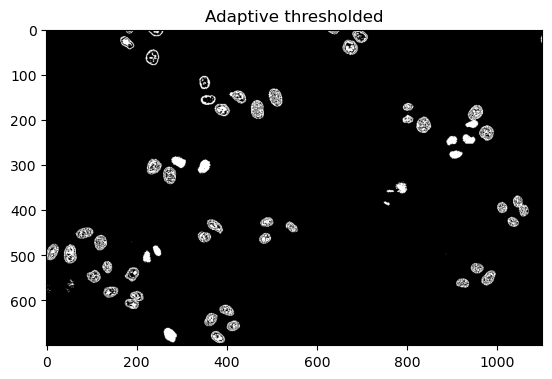

In [67]:
img_test = img_output.astype('uint8')
# img_th = cv2.adaptiveThreshold(img_test, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 5, 2)
_, img_th = cv2.threshold(img_test, 240, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(img_th, 'gray'), plt.title('Adaptive thresholded')
plt.show()

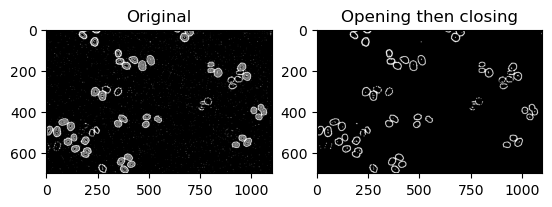

In [63]:
# Open then close operation
img_test = img_th.copy()

kernel = np.ones((3,3),np.uint16)
img1 = cv2.erode(img_test, kernel, iterations=1)
img2 = cv2.dilate(img1, kernel, iterations=1)
# img3 = cv2.dilate(img2, kernel, iterations=2)
# img4 = cv2.erode(img3, kernel, iterations=2)
plt.subplot(1,2,1),plt.imshow(img_test, 'gray'), plt.title('Original')
plt.subplot(1,2,2),plt.imshow(img2, 'gray'), plt.title('Opening then closing')
plt.show()

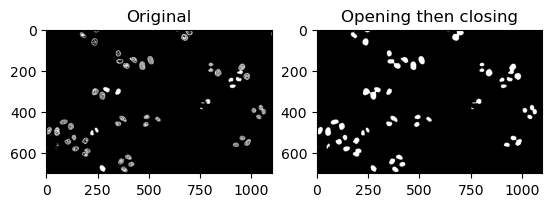

In [90]:
# Open then close operation
img_test = img_th.copy()

kernel = np.ones((5,5),np.uint16)
img1 = cv2.dilate(img_test, kernel, iterations=1)
img2 = cv2.erode(img1, kernel, iterations=1)
img3 = cv2.dilate(img2, kernel, iterations=2)
img4 = cv2.erode(img3, kernel, iterations=2)
kernel = np.ones((3,3),np.uint16)
img5 = cv2.erode(img4, kernel, iterations=1)
img6 = cv2.dilate(img5, kernel, iterations=1)
plt.subplot(1,2,1),plt.imshow(img_test, 'gray'), plt.title('Original')
plt.subplot(1,2,2),plt.imshow(img6, 'gray'), plt.title('Opening then closing')
plt.show()

img_output = img6.copy()

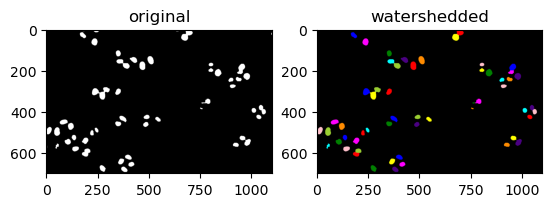

In [91]:
# Watershed implementation
img_test = img_output.copy()
distance = ndi.distance_transform_edt(img_test)

coords = peak_local_max(distance, min_distance=7)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers = ndi.label(mask)[0]

# coords = peak_local_max(distance, labels=img_array)


segmented_cells = watershed(-distance, markers, mask=img_test)

plt.subplot(1,2,1),plt.imshow(img_test, 'gray'), plt.title('original')
plt.subplot(1,2,2),plt.imshow(label2rgb(segmented_cells, bg_label=0)), plt.title('watershedded')
plt.show()

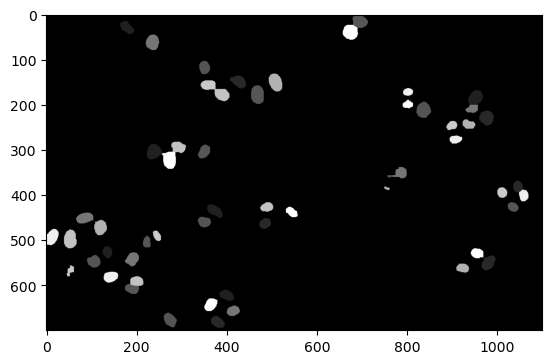

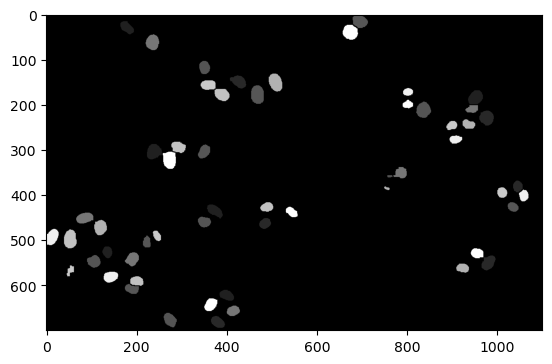

56


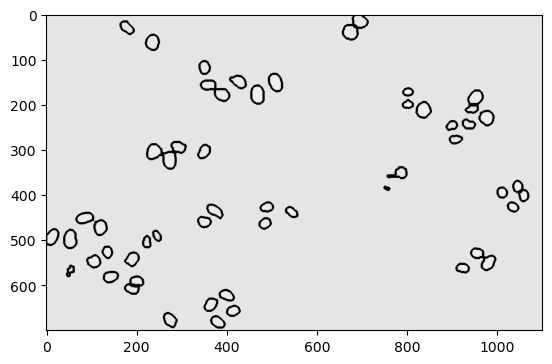

In [116]:
img_seg = label2rgb(segmented_cells, bg_label=0)

for i in range(len(img_seg)):
    for j in range(len(img_seg[0])):
        img_seg[i][j][0] = int(img_seg[i][j][0]*255)
        img_seg[i][j][1] = int(img_seg[i][j][1]*255)
        img_seg[i][j][2] = int(img_seg[i][j][2]*255)

img_seg = img_seg.astype('uint8')
img_seg = cv2.cvtColor(img_seg, cv2.COLOR_RGB2GRAY)
plt.imshow(img_seg, 'gray')
plt.show()

new_img_seg = img_seg.copy()
for i in range(len(img_seg)):
    for j in range(len(img_seg[0])):
        pixel = img_seg[i][j]
        if (pixel != 0):
            found = False
            for a in range(-1, 2):
                for b in range(-1,2):
                    if img_seg[i+a][j+b] != 0 and img_seg[i+a][j+b] != pixel:
                        found = True
                        break
                if (found):
                    break
            if (found):
                new_img_seg[i][j] = 0
            
plt.imshow(new_img_seg, 'gray')
plt.show()


_, contours, _ = cv2.findContours(new_img_seg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
img_contour = cv2.drawContours(img, contours, -1, (0,255,0), 3)
plt.imshow(img_contour, 'gray')
plt.show()

1625


In [113]:
for i in range(-1,2):
    print(i)

-1
0
1
